In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go
from baseFunctions import *
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
train = pd.read_csv('../train.csv')
oil = pd.read_csv('../oil.csv')
stores = pd.read_csv('../stores.csv')
transactions = pd.read_csv('../transactions.csv')
test = pd.read_csv('../test.csv')
holidays = pd.read_csv('../holidays_events.csv')
sampleSub = pd.read_csv('../sample_submission.csv')

# check how to make data staionary

In [21]:
testPair = train.loc[(train.store_nbr == 6) & (train.family == 'BEAUTY')]
testPair.set_index('date', inplace=True)

<Axes: xlabel='date'>

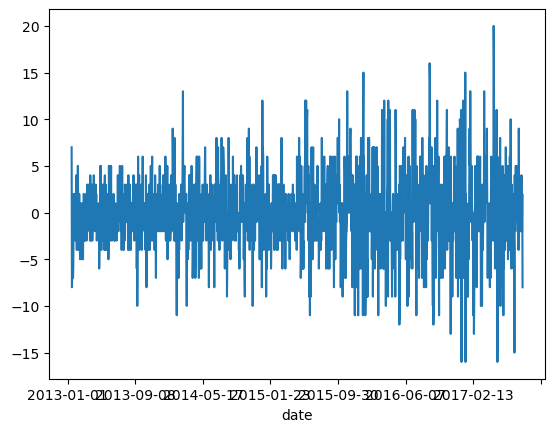

In [22]:
testPair.sales.diff(14).plot()

/Users/matthiaskargl/Codes/kaggle/store-sales-time-series-forecasting/analysis/baseFunctions.py:56: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



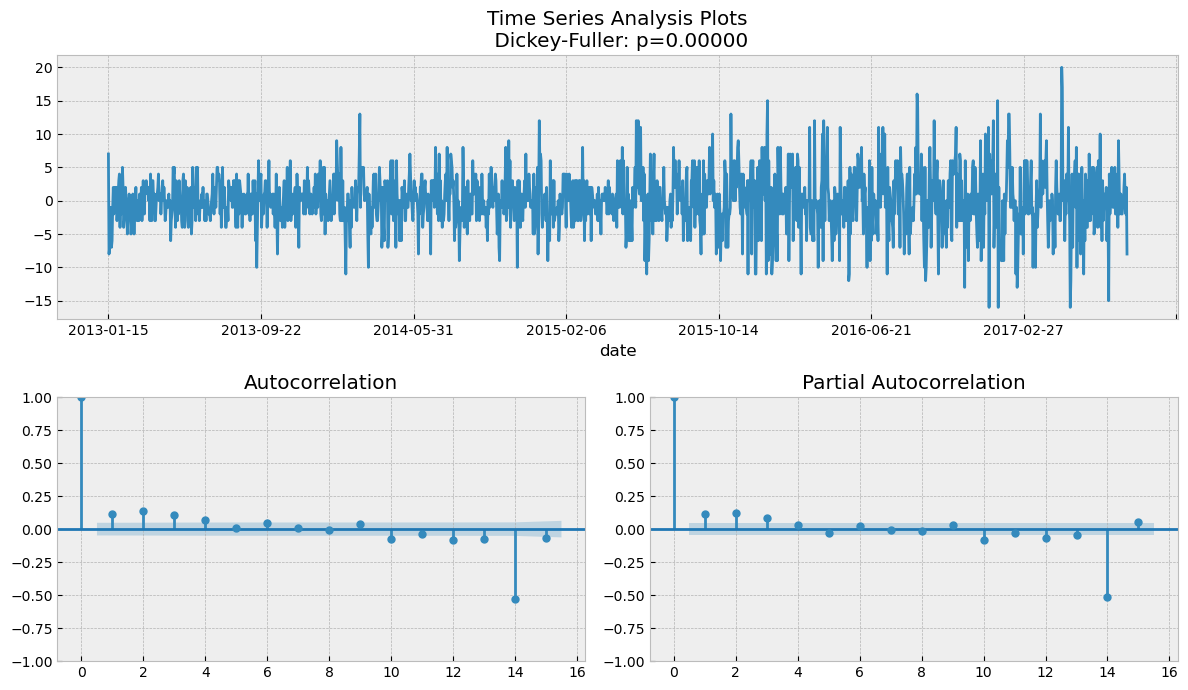

In [23]:
# peak at 14 -> predict 2 week difference
# ACF: MA (moving average) part = how many last errors we include, e.g. error at t-1, t-2,.. -> 3-4 last erors
# PACF: AR (autoregressive) part = how many lags we include                                  -> 3 lags
tsplot(testPair.sales.diff(14).dropna(),lags = 15)

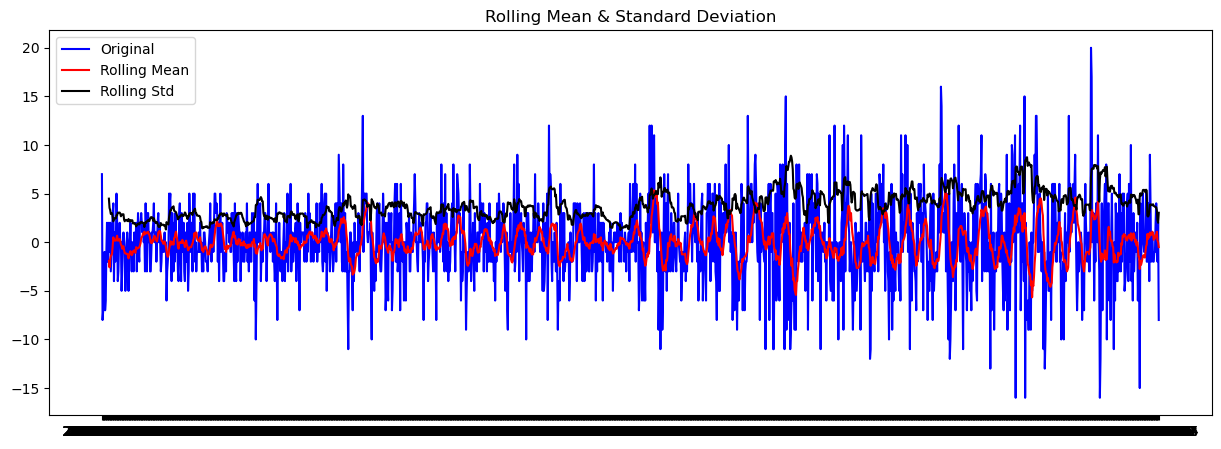

Results of Dickey-Fuller Test:
Test Statistic                -1.434382e+01
p-value                        1.049146e-26
#Lags Used                     1.600000e+01
Number of Observations Used    1.653000e+03
Critical Value (1%)           -3.434312e+00
Critical Value (5%)           -2.863290e+00
Critical Value (10%)          -2.567702e+00
dtype: float64


In [24]:
test_stationarity(testPair.sales.diff(14).dropna())

# preparing data

In [60]:
testPair['target'] = testPair.sales.diff(14)
testPair['shiftedSales14'] = testPair.sales.shift(14)

n_lags = 3
for n in range(n_lags):
    l = n+1
    testPair['target_lag'+str(l)] = testPair['target'].shift(l)

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_68941/3109159316.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_68941/3109159316.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_68941/3109159316.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [61]:
testPair['date'] = pd.to_datetime(testPair['date'])
mask = testPair.date < pd.to_datetime("2017-01-1")
y_train = testPair['sales'][mask]
y_test = testPair['sales'][~mask]

KeyError: 'date'

# predicting stuff

## Arima

~ 0.7 rmsle

In [39]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.7380721516135471


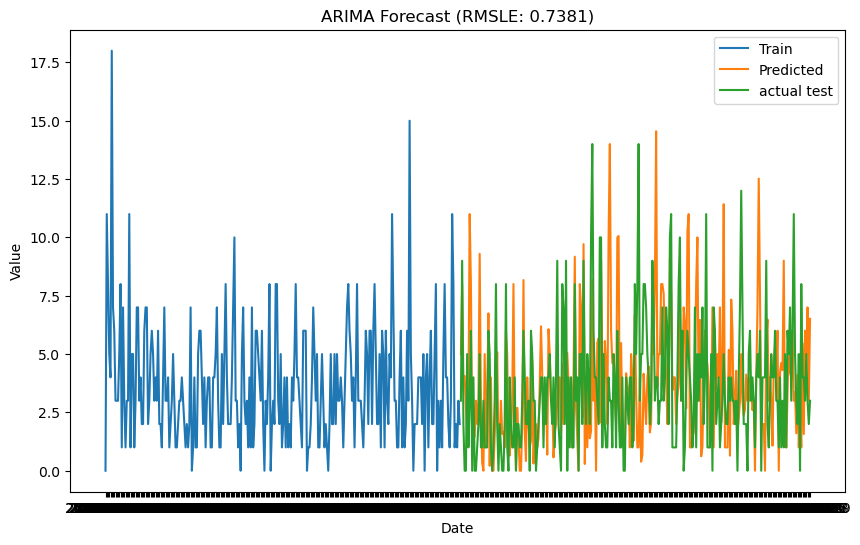

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836

0.6785449398322774


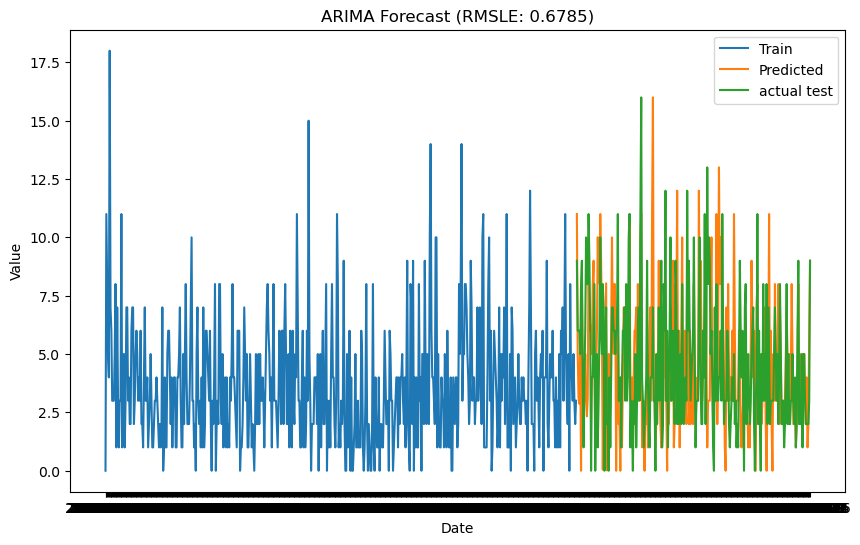

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmode

0.6640458892128454


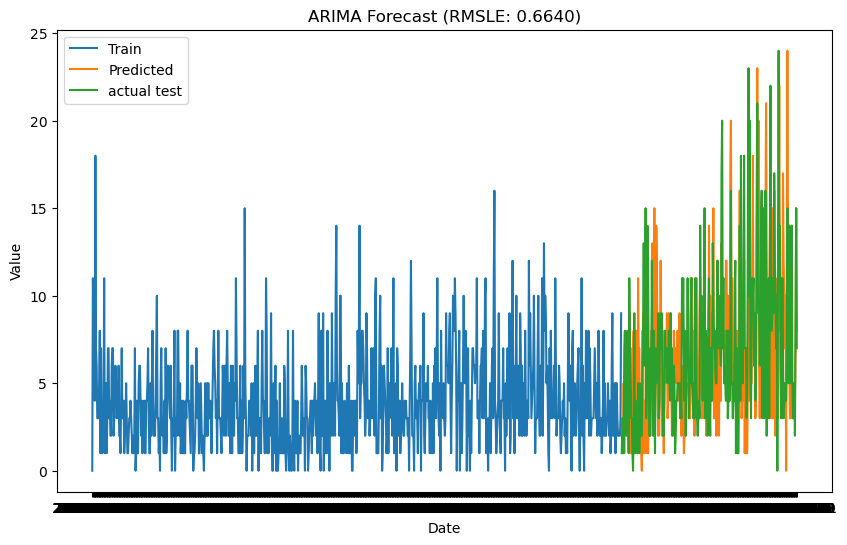

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmode

0.5800253191273078


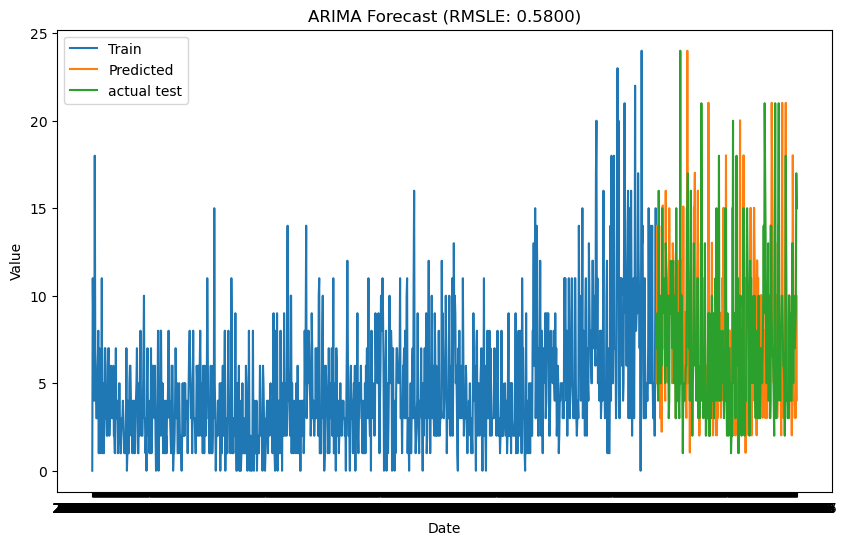

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/matthiaskargl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836

0.6894178929222761


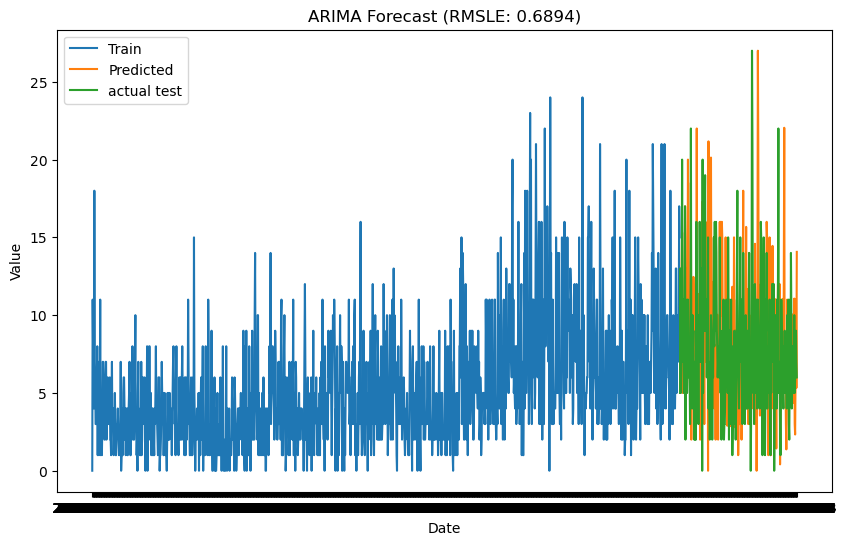

In [70]:
p, d, q = 3,0,3
tscv = TimeSeriesSplit(n_splits=5)

# Initialize an empty list to store ARIMA models
arima_models = []
time_index = testPair.index
for train_index, test_index in tscv.split(testPair):
    train_data = testPair.iloc[train_index]['target']
    test_data = testPair.iloc[test_index]['target']
    salesTrain = testPair.iloc[train_index]['sales']
    shiftedSalesTest = testPair.iloc[test_index]['shiftedSales14']

    # Fit ARIMA model
    model = ARIMA(train_data, order=(p, d, q))
    model_fit = model.fit()

    # Store the trained model
    arima_models.append(model_fit)

    forecast_steps = len(test_data)
    forecast = np.clip(model_fit.forecast(steps=forecast_steps), 0, 1e19)

    gtSales = test_data+ shiftedSalesTest
    predictedSales = forecast.values+ shiftedSalesTest

    # Calculate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(test_data+ shiftedSalesTest, forecast.values+ shiftedSalesTest))
    print(rmsle)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(time_index[train_index], salesTrain, label='Train')
    plt.plot(time_index[test_index], predictedSales, label='Predicted')
    plt.plot(time_index[test_index], gtSales, label='actual test')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'ARIMA Forecast (RMSLE: {rmsle:.4f})')
    plt.legend()
    plt.show()


## LSTM

In [76]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
tf.random.set_seed(42)

In [78]:
testPair.columns
featuresTrain = [
    #'sales', 
    'onpromotion', 
    #'target',
       'target_lag1', 'target_lag2', 'target_lag3']#, 'shiftedSales14']

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'target',
       'target_lag1', 'target_lag2', 'target_lag3', 'shiftedSales14'],
      dtype='object')

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create an LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(look_back, n_features)))
    model.add(Dense(1))  # Single output for univariate forecasting

    # Compile and train the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32)

    # Evaluate on the test set
    rmsle = calculate_rmsle(model.predict(X_test), y_test)
    print(f'RMSLE for fold: {rmsle:.4f}')
